# Installation

In [1]:
!pip install absl-py jax jaxlib dm-env dm-haiku bsuite

# Packages

In [2]:
from copy import deepcopy
from functools import partial
from typing import Callable, List, NamedTuple, Tuple, Union

import dm_env
import haiku as hk
import jax
import numpy as np
from bsuite.baselines import experiment
from bsuite.baselines.utils import sequence
from bsuite.baselines.base import Agent
from bsuite.environments.base import Environment
from dm_env import specs
from jax import numpy as jnp

In [3]:
Horizon = int
Observation = Union[int, np.ndarray, jnp.ndarray]
Action = int
Features = Union[np.ndarray, jnp.ndarray]
BasisFunction = Callable[[Horizon, Observation, Action], jnp.ndarray]


class AgentState(NamedTuple):
    params_mean: jnp.ndarray
    params_cov: jnp.ndarray
    params_sample: jnp.ndarray

# Environment

In [4]:
class ChainEnv(Environment):
    bsuite_num_episodes = 0

    def __init__(
        self,
        size: int = 10,
        deterministic: bool = False,
        seed: int = None,
    ):
        super().__init__()
        self._size = size
        self._deterministic = deterministic
        self._rng = np.random.RandomState(seed)
        if not self._deterministic:
            self._optimal_return = (1 - 1 / self._size)**(self._size - 1)
        else:
            self._optimal_return = 1.
        self._total_regret = 0
        self._reward_seq = []
        self._regret_seq = []
        self._reset()

    def _reset(self) -> dm_env.TimeStep:
        self._timestep = 0
        self._position = 0
        return dm_env.restart(self._get_observation())

    def _step(
        self,
        action: int,
    ) -> dm_env.TimeStep:
        if (action == 1) and (not self._deterministic) and (self._rng.rand() <
                                                            1. / self._size):
            action = 0
        self._timestep += 1
        self._position = max(
            0, min(self._position + 2 * action - 1, self._size - 1))
        observation = self._get_observation()
        reward = int(observation == self._size - 1)
        if self._timestep == self._size - 1:
            self._total_regret += self._optimal_return - reward
            self._reward_seq.append(reward)
            self._regret_seq.append(self._total_regret)
            self.bsuite_num_episodes += 1
            self.print_info()
            return dm_env.termination(reward=reward, observation=observation)
        return dm_env.transition(reward=reward, observation=observation)

    def _get_observation(self):
        obs = self._position
        return obs

    def observation_spec(self):
        return specs.DiscreteArray(self._size, name='position')

    def action_spec(self):
        return specs.DiscreteArray(2, name='action')

    def bsuite_info(self):
        return dict(total_regret=self._total_regret)

    def print_info(self):
        info = 'episode = {} '.format(self.bsuite_num_episodes) + '|'
        info += 'total return = {}'.format(int(sum(self._reward_seq))) + '|'
        info += 'total regret = {:.2f}'.format(self._total_regret) 
        print(info)

# Basis function

In [5]:
def random_coherent_basis(
    size: int,
    deterministic: bool,
    num_basis: int,
    rng: hk.PRNGSequence,
) -> BasisFunction:

    S = size
    A = 2
    H = S - 1
    K = num_basis
    if deterministic:
        p = 1.
    else:
        p = (1 - 1. / S)

    # optimal state value function
    aux = np.array([p**t for t in range(H, 0, -1)])
    aux = np.tril(jnp.ones(H)) @ np.diag(aux)
    aux = np.cumsum(aux[:, ::-1], axis=1)[:, ::-1]
    v_opt = np.concatenate([aux, aux[-1:, :]], axis=0).T

    # optimal state-action value function
    q_right = v_opt
    q_left = np.zeros((H, S))
    q_left[:-1, 1:] = v_opt[1:, :-1]
    q_opt = np.stack([q_left, q_right], axis=2)

    # coherent basis
    psi_ones = jnp.ones(shape=(H * S * A, 1))
    psi_opt = jnp.reshape(q_opt, [H * S * A, 1])
    psi_rand = jax.random.normal(next(rng), shape=(H * S * A, K - 2))
    psi = jnp.concatenate([psi_ones, psi_opt, psi_rand], axis=1)
    proj = psi @ jnp.linalg.inv(psi.T @ psi) @ psi.T
    w_ones = jnp.ones(shape=(H * S * A, 1))
    w_rand = jax.random.normal(next(rng), shape=(H * S * A, K - 1))
    w = jnp.concatenate([w_ones, w_rand], axis=1)
    w_proj = proj @ w
    w_proj /= jnp.linalg.norm(w_proj, axis=0)
    w_proj *= H * S * A
    phi = w_proj.reshape(H, S, A, K)

    # basis function
    def basis_function(h, s, a):
        return phi[h, s, a].squeeze()

    return basis_function

# Randomized LSVI

In [6]:
@jax.jit
def _argmax(
    f: jnp.ndarray,
    p: jnp.ndarray,
) -> jnp.ndarray:
    q = jnp.matmul(f, p)
    a = jnp.argmax(q, axis=-1)
    return a.squeeze()


@jax.jit
def _max(
    f: jnp.ndarray,
    p: jnp.ndarray,
) -> jnp.ndarray:
    q = jnp.matmul(f, p)
    q_max = jnp.max(q, axis=-1)
    return q_max.squeeze()


@jax.jit
def _sample(
    rng: hk.PRNGSequence,
    m: jnp.ndarray,
    c: jnp.ndarray,
) -> jnp.ndarray:
    s = jax.random.multivariate_normal(rng, m, c)
    return s


@partial(jax.jit, static_argnums=(3, ))
def _lstsq(
    A: jnp.ndarray,
    b: jnp.ndarray,
    reg_parameter: float,
) -> Tuple[jnp.ndarray, jnp.ndarray]:

    # get parameters covariance
    inv_cov = jnp.matmul(A.T, A) + reg_parameter * jnp.eye(A.shape[1])
    cov = jnp.linalg.inv(inv_cov)

    # get parameters mean
    mean = jnp.dot(jnp.matmul(cov, A.T), b)

    return mean, cov


def _rlsvi(
    agent_state: AgentState,
    basis_function: BasisFunction,
    trajectories: List[sequence.Trajectory],
    noise_std: float,
    reg_parameter: float,
    sequence_length: int,
    rng: hk.PRNGSequence,
) -> AgentState:

    basis_function = jax.vmap(basis_function)

    observations = jnp.stack([t.observations for t in trajectories])
    actions = jnp.stack([t.actions for t in trajectories])
    rewards = jnp.stack([t.rewards for t in trajectories])

    params_mean, params_cov, params_sample = [], [], []

    for h in range(sequence_length)[::-1]:

        # get regression matrix
        batch_h = h * jnp.ones(len(observations), dtype=int)
        batch_o = observations[:, h]
        batch_a = actions[:, h]
        batch_f = basis_function(batch_h, batch_o, batch_a)
        A = batch_f / noise_std

        # get regression vector
        batch_r = rewards[:, h]
        batch_next_o = observations[:, h + 1]
        if h == sequence_length - 1:
            batch_next_r = rewards[:, -1]
        else:
            batch_next_f = basis_function(batch_h + 1, batch_next_o, None)
            next_p = params_sample[-1]
            batch_next_r = _max(batch_next_f, next_p)
        b = (batch_r + batch_next_r) / noise_std

        # get parameters
        mean, cov = _lstsq(A, b, reg_parameter)
        sample = _sample(next(rng), mean, cov)
        params_mean.append(mean)
        params_cov.append(cov)
        params_sample.append(sample)

    return agent_state._replace(params_mean=params_mean[::-1],
                                params_cov=params_cov[::-1],
                                params_sample=params_sample[::-1])

# Agent

In [7]:
class RLSVI(Agent):
    def __init__(
        self,
        obs_spec: specs.Array,
        action_spec: specs.DiscreteArray,
        basis_function: BasisFunction,
        sequence_length: int,
        noise_std: float,
        reg_parameter: float,
        rng: hk.PRNGSequence,
    ):

        self._obs_spec = obs_spec
        self._action_spec = action_spec
        self._sequence_length = sequence_length
        self._basis_function = basis_function
        self._noise_std = noise_std
        self._reg_parameter = reg_parameter
        self._rng = rng

        # initialize buffer
        self._trajectories = []
        self._buffer = sequence.Buffer(obs_spec, action_spec, sequence_length)

        # initialize parameters
        self._state = AgentState(None, None, None)

    def update(
        self,
        timestep: dm_env.TimeStep,
        action: Action,
        new_timestep: dm_env.TimeStep,
    ):

        self._buffer.append(timestep, action, new_timestep)
        if self._buffer.full() or new_timestep.last():
            trajectory = self._buffer.drain()
            self._trajectories.append(deepcopy(trajectory))
            self._state = _rlsvi(self._state, self._basis_function,
                                 self._trajectories, self._noise_std,
                                 self._reg_parameter, self._sequence_length,
                                 self._rng)

    def select_action(
        self,
        timestep: dm_env.TimeStep,
    ) -> Action:

        if self._state.params_sample == None:
            action = jax.random.randint(next(self._rng), (), 0,
                                        self._action_spec.num_values)
            return int(action)

        h = int(timestep.step_type)
        o = timestep.observation
        f = jnp.stack([
            self._basis_function(h, o, a)
            for a in range(self._action_spec.num_values)
        ],
                      axis=0)
        p = self._state.params_sample[h]
        action = _argmax(f, p)

        return int(action)

# Parameters

In [8]:
seed = 1234 # Random seed
size = 20 # Size of chain experiment
deterministic = False # Deterministic environment
num_basis = 10 # Number of basis functions
noise_std = 0.1 # Standard deviation of RLSVI
reg_parameter = 1. # Regularization parameter of RLSVI
num_episodes = 300 # Number of train episodes


# Experiment

In [9]:
key = jax.random.PRNGKey(seed)
rng = hk.PRNGSequence(key)

# set environment
env = ChainEnv(size=size, deterministic=deterministic, seed = seed)

# set basis function
basis_function = random_coherent_basis(size=size,
                                        deterministic=deterministic,
                                        num_basis=num_basis,
                                        rng=rng)

# set agent
agent = RLSVI(obs_spec=env.observation_spec(),
                action_spec=env.action_spec(),
                basis_function=basis_function,
                sequence_length=size,
                noise_std=noise_std,
                reg_parameter=reg_parameter,
                rng=rng)

# run experiment
experiment.run(agent=agent,
                environment=env,
                num_episodes=num_episodes,
                verbose=True)


episode = 1 |total return = 0|total regret = 0.38
episode = 2 |total return = 0|total regret = 0.75
episode = 3 |total return = 0|total regret = 1.13
episode = 4 |total return = 0|total regret = 1.51
episode = 5 |total return = 0|total regret = 1.89
episode = 6 |total return = 0|total regret = 2.26
episode = 7 |total return = 0|total regret = 2.64
episode = 8 |total return = 0|total regret = 3.02
episode = 9 |total return = 0|total regret = 3.40
episode = 10 |total return = 0|total regret = 3.77
episode = 11 |total return = 0|total regret = 4.15
episode = 12 |total return = 0|total regret = 4.53
episode = 13 |total return = 0|total regret = 4.91
episode = 14 |total return = 0|total regret = 5.28
episode = 15 |total return = 0|total regret = 5.66
episode = 16 |total return = 0|total regret = 6.04
episode = 17 |total return = 0|total regret = 6.42
episode = 18 |total return = 0|total regret = 6.79
episode = 19 |total return = 0|total regret = 7.17
episode = 20 |total return = 0|total reg

# Results

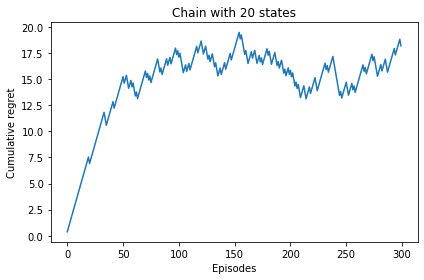

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x = range(env.bsuite_num_episodes)
y = env._regret_seq

ax.plot(x,y)

ax.set_xlabel('Episodes')
ax.set_ylabel('Cumulative regret')
ax.set_title('Chain with {} states'.format(size))

fig.tight_layout()

plt.show()